<a href="https://colab.research.google.com/github/JunXinVan/Dynamic-workload-allocation-mechanism-for-content-moderatorss/blob/main/%E2%80%9CSteffen_Bollman_Deep_learning_QSM_tutorial_OHBM_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro


Disclaimer: This code is not the DeepQSM source code used in the publications and was newly written for the OHBM educational course.

Intro to Jupyter/Colab notebooks & Keras from last year's course:
https://colab.research.google.com/github/akeshavan/IntroDL/blob/master/IntroToKeras.ipynb



# QSM data from the 2018 reconstruction challenge


## Download data to google drive

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
!mkdir -p /content/gdrive/My\ Drive/dlqsm
os.chdir("/content/gdrive/My Drive/dlqsm")

Mounted at /content/gdrive


In [ ]:
# uncomment to download the data again
!wget -nc http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
!unzip -uo 20170327_qsm2016_recon_challenge.zip

File ‘20170327_qsm2016_recon_challenge.zip’ already there; not retrieving.

Archive:  20170327_qsm2016_recon_challenge.zip


## View QSM data

In [ ]:
import matplotlib.pyplot as plt

def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
  print('Matrix size: {}'.format(image_3d.shape))
  fig = plt.figure(figsize=(6, 3))
  plt.suptitle(title, fontsize=10)

  plt.subplot(131)
  plt.imshow(np.take(image_3d, slice_nbr, 2), vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Axial');

  plt.subplot(132)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Coronal');

  plt.subplot(133)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Sagittal');
  cbar=plt.colorbar()

<ipython-input-7-339620ab7933>:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  brain_fw_full = nib.load('20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
<ipython-input-7-339620ab7933>:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  brain_gt_full = nib.load('20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


Matrix size: (160, 160, 160)
Matrix size: (160, 160, 160)


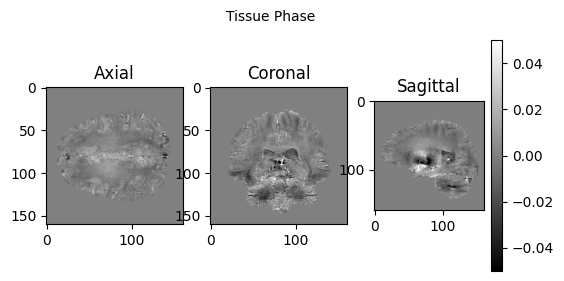

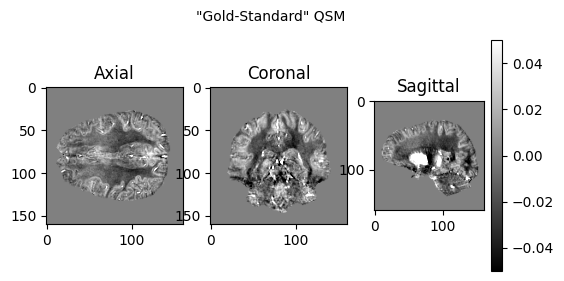

In [ ]:
import nibabel as nib
import numpy as np
from matplotlib import transforms
from scipy import ndimage

# load data
brain_fw_full = nib.load('20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
brain_gt_full = nib.load('20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()

view_slices_3d(brain_fw_full, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(brain_gt_full, slice_nbr=100, vmin=-0.05, vmax=0.05, title='"Gold-Standard" QSM')

# Simulate susceptibility sources and tissue phase



## Simulate susceptibility distribution

In [ ]:
import numpy as np

def simulate_susceptibility_sources(simulation_dim = 160,
                                    rectangles_total = 100,
                                    spheres_total = 80,
                                    sus_std = 1,     # standard deviation of susceptibility values
                                    shape_size_min_factor = 0.01,
                                    shape_size_max_factor = 0.5):

  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim))


  for shapes in range(rectangles_total):
      shrink_factor = 1/((shapes/rectangles_total+1))
      shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
      shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)

      print(shape_size_min)
      print(shape_size_max)
      print('---------------')

      susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
      random_sizex = np.random.randint(low=shape_size_min, high=shape_size_max)
      random_sizey = np.random.randint(low=shape_size_min, high=shape_size_max)
      random_sizez = np.random.randint(low=shape_size_min, high=shape_size_max)
      x_pos = np.random.randint(simulation_dim)
      y_pos = np.random.randint(simulation_dim)
      z_pos = np.random.randint(simulation_dim)

      x_pos_max = x_pos + random_sizex
      if x_pos_max >= simulation_dim:
          x_pos_max = simulation_dim

      y_pos_max = y_pos + random_sizey
      if y_pos_max >= simulation_dim:
          y_pos_max = simulation_dim

      z_pos_max = z_pos + random_sizez
      if z_pos_max >= simulation_dim:
          z_pos_max = simulation_dim

      temp_sources[x_pos:x_pos_max, y_pos:y_pos_max, z_pos:z_pos_max] = susceptibility_value

  return temp_sources
  #模拟磁化源

3.0
160.0
---------------
3.0
159.0
---------------
3.0
159.0
---------------
3.0
159.0
---------------
3.0
159.0
---------------
3.0
159.0
---------------
3.0
158.0
---------------
3.0
158.0
---------------
3.0
158.0
---------------
3.0
158.0
---------------
3.0
158.0
---------------
3.0
157.0
---------------
3.0
157.0
---------------
3.0
157.0
---------------
3.0
157.0
---------------
3.0
157.0
---------------
3.0
156.0
---------------
3.0
156.0
---------------
3.0
156.0
---------------
3.0
156.0
---------------
3.0
156.0
---------------
3.0
155.0
---------------
3.0
155.0
---------------
3.0
155.0
---------------
3.0
155.0
---------------
3.0
155.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
153.0
---------------
3.0
153.0
---------------
3.0
153.0
---------------
3.0
153.0
---------------
3.0
153.0
---------------
3.0
152.0
---------------
3.0
152.0
--

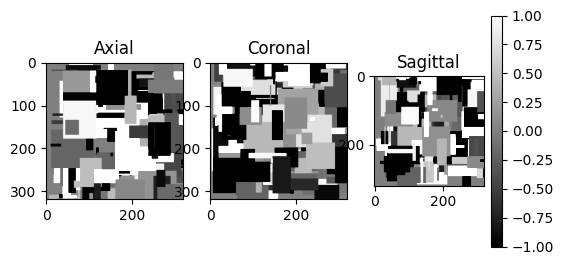

In [ ]:
sim_gt_full = simulate_susceptibility_sources(simulation_dim = 320, rectangles_total = 800, spheres_total = 80,)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

## Convolve Susceptibility Distribution with Dipole Kernel to yield Tissue Phase

In [ ]:
def generate_3d_dipole_kernel(data_shape, voxel_size, b_vec):
    fov = np.array(data_shape) * np.array(voxel_size)

    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                             np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                             np.arange(-data_shape[2] // 2, data_shape[2] // 2))

    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]

    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    kernel = (1 / 3 - d2)

    return kernel
    #加载三维偶极子核

In [ ]:
dipole_kernel = generate_3d_dipole_kernel(sim_gt_full.shape, voxel_size=1, b_vec=[0, 0, 1])

Matrix size: (320, 320, 320)


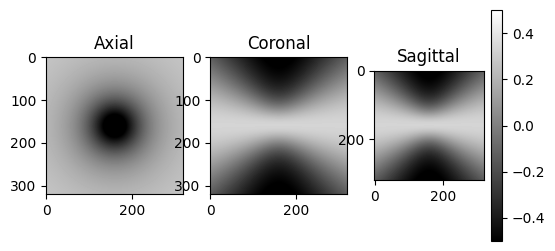

In [ ]:
view_slices_3d(dipole_kernel, slice_nbr=100, vmin=-0.5, vmax=0.5)

In [ ]:
def forward_convolution_padding(chi_sample, padding=20):
    #pad sample to avoid wrap-around at the edges
    padded_sample = np.zeros((chi_sample.shape[0]+2*padding, chi_sample.shape[1]+2*padding, chi_sample.shape[2]+2*padding))
    padded_sample[padding:chi_sample.shape[0]+padding, padding:chi_sample.shape[1]+padding, padding:chi_sample.shape[2]+padding] = chi_sample
    scaling = np.sqrt(padded_sample.size)
    chi_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(padded_sample))) / scaling

    dipole_kernel = generate_3d_dipole_kernel(padded_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    chi_fft_t_kernel = chi_fft * dipole_kernel

    tissue_phase_unscaled = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(chi_fft_t_kernel)))
    tissue_phase = np.real(tissue_phase_unscaled * scaling)

    tissue_phase_cropped = tissue_phase[padding:chi_sample.shape[0]+padding, padding:chi_sample.shape[1]+padding, padding:chi_sample.shape[2]+padding]

    return tissue_phase_cropped

    #先对样本进行padding，在计算fft，归一化，生成三维偶极子核来和fft后的样本相乘
    #再计算逆FFT，归一化；对结果进行剪裁，最终生成组织相位数据（裁剪过）


def forward_convolution(chi_sample):
    scaling = np.sqrt(chi_sample.size)
    chi_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(chi_sample))) / scaling

    chi_fft_t_kernel = chi_fft * generate_3d_dipole_kernel(chi_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(chi_fft_t_kernel)))
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase
#上面的函数去除了padding，直接在原始样本上卷积，计算MRI组织相位数据
sim_fw_full = forward_convolution(sim_gt_full)

Matrix size: (320, 320, 320)


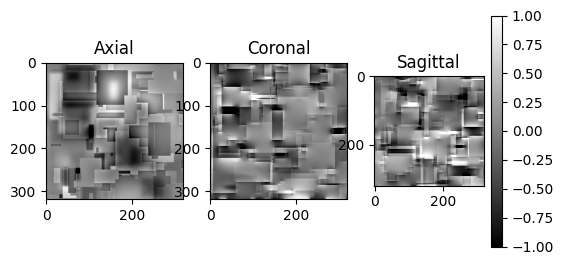

In [ ]:
view_slices_3d(sim_fw_full, slice_nbr=100, vmin=-1, vmax=1)

Matrix size: (320, 320, 320)


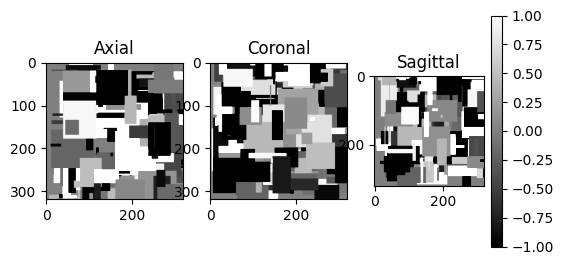

In [ ]:
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

#Train a model to invert the dipole convolution using Keras & Tensorflow

## Prepare patches for training

Due to memory limits on the GPUs and to get more training examples we will cut smaller patches from our simulated data



In [ ]:
def cut_patch(dim, patch_idx, gt_full, fw_full):
    x_max, y_max, z_max = gt_full.shape

    randomX = np.random.randint(0, x_max - training_dim)
    randomY = np.random.randint(0, y_max - training_dim)
    randomZ = np.random.randint(0, z_max - training_dim)

    gt_patch = gt_full[randomX:randomX + training_dim, randomY:randomY + training_dim, randomZ:randomZ + training_dim]
    fw_patch = fw_full[randomX:randomX + training_dim, randomY:randomY + training_dim, randomZ:randomZ + training_dim]

    return gt_patch, fw_patch
    #因为GPU的内存限制，这边选择用ground truth和前向模拟数据来生成三维的patch用于训练

In [ ]:

patches_total = 500
training_dim = 64
import numpy as np
# Cut patches from our simulations for training
sim_gt_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))
sim_fw_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))

for patch_idx in range(patches_total):
  sim_gt_patches[patch_idx, :, :, :], sim_fw_patches[patch_idx, :, :, :] = cut_patch(training_dim, patch_idx, sim_gt_full, sim_fw_full)

# Cut test data patches from a real brain
brain_gt_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))
brain_fw_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))
for patch_idx in range(patches_total):
  brain_gt_patches[patch_idx, :, :, :], brain_fw_patches[patch_idx, :, :, :] = cut_patch(training_dim, patch_idx, brain_gt_full, brain_fw_full)
  #调用此前生成小块的函数，进一步裁剪出三维的小块，500个64^3的三维小块

Matrix size: (64, 64, 64)
Matrix size: (64, 64, 64)


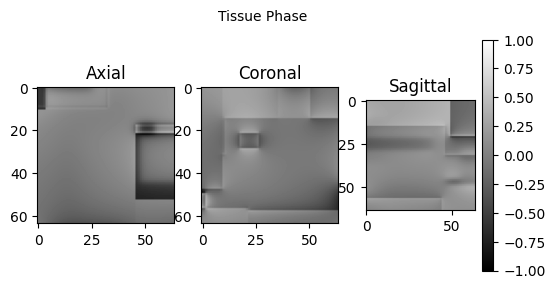

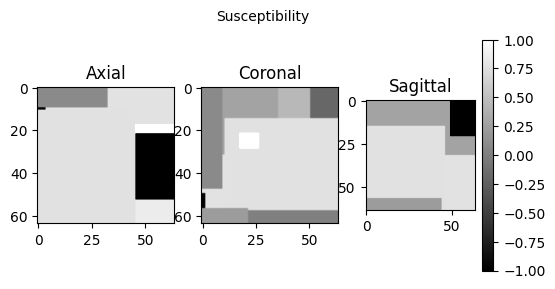

In [ ]:
patch_idx = 44
view_slices_3d(sim_fw_patches[patch_idx, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='Tissue Phase')
view_slices_3d(sim_gt_patches[patch_idx, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='Susceptibility')
#随机选取一个小切片进行观测

## Build a model
based on
* https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/pix2pix.ipynb#scrollTo=tqqvWxlw8b4l


* https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb#scrollTo=MPkvHdAYNt9J

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0
2.15.0


SystemError: GPU device not found

In [ ]:
OUTPUT_CHANNELS = 1
def downsample(filters, kernel_size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result
 #定义下采样函数，三维CNN，条件性添加BN层

In [ ]:
# bringing things in the right shape for the network (first dimension is batch, then xyz, last dimension is channel)
inp = sim_fw_patches[ 0, :, :, :]
print(inp.shape)
inp = tf.expand_dims(inp, 0)
print(inp.shape)
inp = tf.expand_dims(inp, 4)
print(inp.shape)

In [ ]:
# testing downsample part
down_model = downsample(filters=8, kernel_size=4)
down_result = down_model(inp)
print (down_result.shape)

In [ ]:
def upsample(filters, kernel_size, apply_dropout=False, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  if apply_batchnorm:
      result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
  #上采样

In [ ]:
# Testing upsample part
up_model = upsample(filters=8, kernel_size=4)
up_result = up_model(down_result)
print (up_result.shape)

In [ ]:
# Parameters for all Models
import pickle


epochs_train = 200
save_period = 20


# Train Model 1

## Prepare

In [ ]:
def architecture1(filter_base=32, kernel_size=3):
  down_stack = [
    downsample(filter_base, kernel_size, apply_batchnorm=False), # (bs, 32xxx 64 if filter base = 64)
    downsample(filter_base*2, kernel_size), # (bs, 16xxx, 128)
    downsample(filter_base*3, kernel_size), # (bs, 8xxx, 256)
    downsample(filter_base*4, kernel_size), # (bs, 4xxx, 512)
    downsample(filter_base*5, kernel_size), # (bs, 2xxx, 512)
  ]

  up_stack = [
    upsample(filter_base*5, kernel_size, apply_dropout=True), # (bs, 4xxx 1024)
    upsample(filter_base*4, kernel_size, apply_dropout=True), # (bs, 8xxxx 512)
    upsample(filter_base*3, kernel_size), # (bs, 16xxx 256)
    upsample(filter_base*2, kernel_size), # (bs, 32xxx 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS, kernel_size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,None,1])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
import tensorflow as tf

def upsample(filters, kernel_size, apply_dropout=False, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def Attention_block(F_g, F_l, F_int):
    g_conv = tf.keras.layers.Conv3D(F_g, kernel_size=1, strides=1, padding='same')

    x_conv = tf.keras.layers.Conv3D(F_l, kernel_size=1, strides=1, padding='same')
    psi = tf.keras.layers.Conv3D(F_int, kernel_size=1, strides=1, padding='same')
    def func(g, x):
        g1 = g_conv(g)
        x1 = x_conv(x)
        psi_val = tf.nn.relu(g1 + x1)
        psi_val = psi(psi_val)
        psi_val = tf.nn.sigmoid(psi_val)

        return x * psi_val

    return func
    class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

def AttentionUNet(filter_base=32, kernel_size=3):
    down_stack = [
        downsample(filter_base, kernel_size, apply_batchnorm=False),
        downsample(filter_base*2, kernel_size),
        downsample(filter_base*3, kernel_size),
        downsample(filter_base*4, kernel_size),
        downsample(filter_base*5, kernel_size)
    ]

    up_stack = [
        upsample(filter_base*5, kernel_size, apply_dropout=True),
        upsample(filter_base*4, kernel_size, apply_dropout=True),
        upsample(filter_base*3, kernel_size),
        upsample(filter_base*2, kernel_size)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv3DTranspose(1, kernel_size,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    inputs = tf.keras.layers.Input(shape=[None,None,None,1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Attention Blocks
    attention_blocks = [Attention_block(filters*2, filters, filters) for filters in [filter_base*4, filter_base*3, filter_base*2, filter_base]]

    # Upsampling and establishing the skip connections with attention
    for up, skip, attention_block in zip(up_stack, skips, attention_blocks):
        x = up(x)
        x = tf.keras.layers.concatenate([x, skip])
        x = attention_block(x, skip)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

IndentationError: expected an indented block after class definition on line 51 (<ipython-input-61-363c4e9285c6>, line 52)

In [ ]:
import tensorflow as tf
#非该网页自带upsample，downsample
def upsample(filters, kernel_size, apply_dropout=False, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def Attention_block(F_g, F_l, F_int):
    g_conv = tf.keras.layers.Conv3D(F_g, kernel_size=1, strides=1, padding='same')
    x_conv = tf.keras.layers.Conv3D(F_l, kernel_size=1, strides=1, padding='same')
    psi = tf.keras.layers.Conv3D(F_int, kernel_size=1, strides=1, padding='same')
    def func(g, x):
        g1 = g_conv(g)
        x1 = x_conv(x)
        psi_val = tf.nn.relu(g1 + x1)
        psi_val = psi(psi_val)
        psi_val = tf.nn.sigmoid(psi_val)

        return x * psi_val

    return func

def AttentionUNet(filter_base=32, kernel_size=3):
    down_stack = [
        downsample(filter_base, kernel_size, apply_batchnorm=False),
        downsample(filter_base*2, kernel_size),
        downsample(filter_base*3, kernel_size),
        downsample(filter_base*4, kernel_size),
        downsample(filter_base*5, kernel_size)
    ]

    up_stack = [
        upsample(filter_base*5, kernel_size, apply_dropout=True),
        upsample(filter_base*4, kernel_size, apply_dropout=True),
        upsample(filter_base*3, kernel_size),
        upsample(filter_base*2, kernel_size)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv3DTranspose(1, kernel_size,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    inputs = tf.keras.layers.Input(shape=[None,None,None,1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Attention Blocks
    attention_blocks = [Attention_block(filters*2, filters*2, filters) for filters in [filter_base*4, filter_base*3, filter_base*2, filter_base]]

    # Upsampling and establishing the skip connections with attention
    for up, skip, attention_block in zip(up_stack, skips, attention_blocks):
        x = up(x)
        x = tf.keras.layers.concatenate([x, skip])
        x = attention_block(x, skip)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
#网页自带的upsample，downsample
import tensorflow as tf
def upsample(filters, kernel_size, apply_dropout=False, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  if apply_batchnorm:
      result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
  #上采样
def downsample(filters, kernel_size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result
 #定义下采样函数，三维CNN，条件性添加BN层



def Attention_block(F_g, F_l, F_int):
    g_conv = tf.keras.layers.Conv3D(F_g, kernel_size=1, strides=1, padding='same')
    x_conv = tf.keras.layers.Conv3D(F_l, kernel_size=1, strides=1, padding='same')
    psi = tf.keras.layers.Conv3D(F_int, kernel_size=1, strides=1, padding='same')
    def func(g, x):
        g1 = g_conv(g)
        x1 = x_conv(x)
        psi_val = tf.nn.relu(g1 + x1)
        psi_val = psi(psi_val)
        psi_val = tf.nn.sigmoid(psi_val)

        return x * psi_val

    return func
def AttentionUNet1(filter_base=32, kernel_size=3):
    down_stack = [
        downsample(filter_base, kernel_size, apply_batchnorm=False),
        downsample(filter_base*2, kernel_size),
        downsample(filter_base*3, kernel_size),
        downsample(filter_base*4, kernel_size),
        downsample(filter_base*5, kernel_size)
    ]

    up_stack = [
        upsample(filter_base*5, kernel_size, apply_dropout=True),
        upsample(filter_base*4, kernel_size, apply_dropout=True),
        upsample(filter_base*3, kernel_size),
        upsample(filter_base*2, kernel_size)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv3DTranspose(1, kernel_size,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    inputs = tf.keras.layers.Input(shape=[None,None,None,1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Attention Blocks
    attention_blocks = [Attention_block(filters*2, filters*2, filters) for filters in [filter_base*4, filter_base*3, filter_base*2, filter_base]]

    # Upsampling and establishing the skip connections with attention
    for up, skip, attention_block in zip(up_stack, skips, attention_blocks):
        x = up(x)
        x = tf.keras.layers.concatenate([x, skip])
        x = attention_block(x, skip)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model1 = AttentionUNet()
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, None,    0         []                            
                             1)]                                                                  
                                                                                                  
 sequential (Sequential)     (None, None, None, None, 3   864       ['input_1[0][0]']             
                             2)                                                                   
                                                                                                  
 sequential_1 (Sequential)   (None, None, None, None, 6   55552     ['sequential[0][0]']          
                             4)                                                               

In [ ]:
# what does the untrained model predict
test_patch_nbr = 10
X_test = sim_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(X_test.shape)

y_pred = model1.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(sim_gt_patches[test_patch_nbr, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


NameError: name 'sim_fw_patches' is not defined

## Train

In [ ]:
import os

In [ ]:
# train
checkpoint_path1 = "checkpoints1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path1,
                                                 save_weights_only=True,
                                                 period=save_period,
                                                 verbose=1)

train_images=tf.expand_dims(sim_fw_patches, 4)
train_labels=tf.expand_dims(sim_gt_patches, 4)


history1 = model1.fit(train_images, train_labels,  epochs=epochs_train, batch_size=30, shuffle=True,
          callbacks = [cp_callback])  # pass callback to training for saving the model

loss_history1 = history1.history['loss']

with open('loss_history1.pickle', 'wb') as f:
    pickle.dump([loss_history1, epochs_train], f)

Epoch 1/200
17/17 [==============================] - 13s 331ms/step - loss: 0.8089
Epoch 2/200
17/17 [==============================] - 5s 319ms/step - loss: 0.7812
Epoch 3/200
17/17 [==============================] - 6s 328ms/step - loss: 0.7084
Epoch 4/200
17/17 [==============================] - 5s 316ms/step - loss: 0.6200
Epoch 5/200
17/17 [==============================] - 5s 302ms/step - loss: 0.5478
Epoch 6/200
17/17 [==============================] - 6s 337ms/step - loss: 0.4921
Epoch 7/200
17/17 [==============================] - 5s 300ms/step - loss: 0.4453
Epoch 8/200
17/17 [==============================] - 5s 316ms/step - loss: 0.4111
Epoch 9/200
17/17 [==============================] - 5s 305ms/step - loss: 0.3706
Epoch 10/200
17/17 [==============================] - 5s 300ms/step - loss: 0.3436
Epoch 11/200
17/17 [==============================] - 5s 321ms/step - loss: 0.3238
Epoch 12/200
17/17 [==============================] - 5s 297ms/step - loss: 0.2973
Epoch 13/200

## Load and Plot

checkpoints1/cp-0200.ckpt


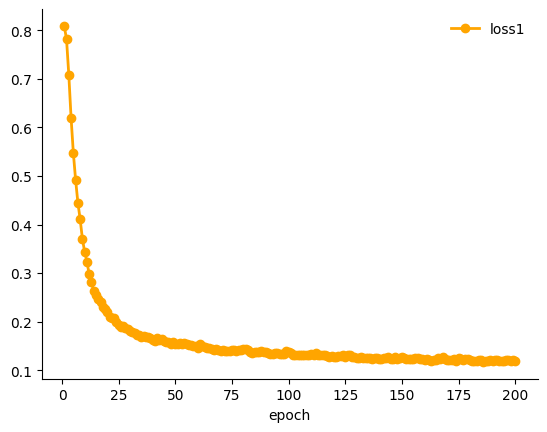

In [ ]:
# load stored data
checkpoint_path1 = "checkpoints1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)

model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
print(latest1)
model1.load_weights(latest1)

with open('loss_history1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="loss1")
ax.set_xlabel('epoch')
ax.legend(frameon=False);


(1, 64, 64, 64, 1)
1/1 [==============================] - 0s 341ms/step
(1, 64, 64, 64, 1)
Matrix size: (64, 64, 64)
Matrix size: (64, 64, 64)
Matrix size: (64, 64, 64)


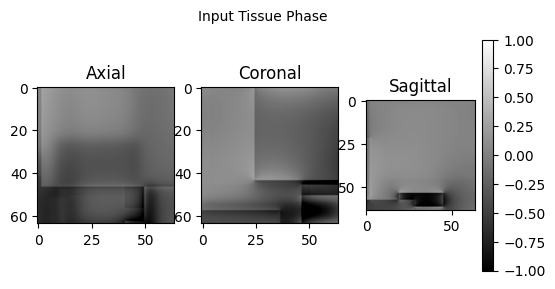

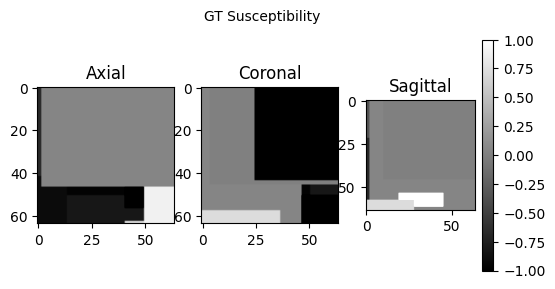

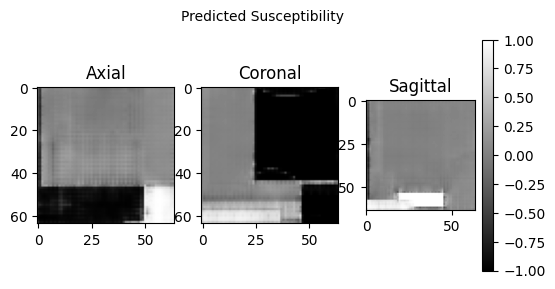

In [ ]:
# did we manage to learn the training data?
test_patch_nbr = 4
X_test = sim_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(X_test.shape)

y_pred = model1.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(sim_gt_patches[test_patch_nbr, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


(1, 320, 320, 320, 1)
1/1 [==============================] - 0s 482ms/step
(1, 320, 320, 320, 1)
Matrix size: (320, 320, 320)
Matrix size: (320, 320, 320)


Matrix size: (320, 320, 320)


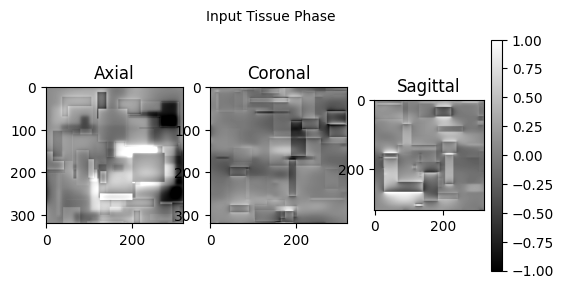

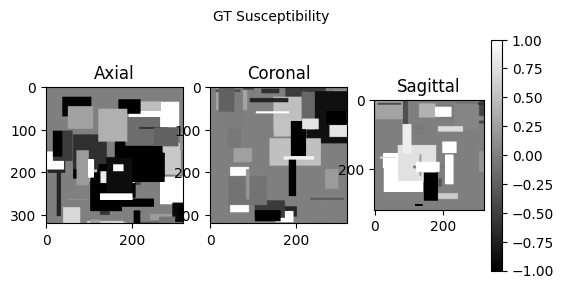

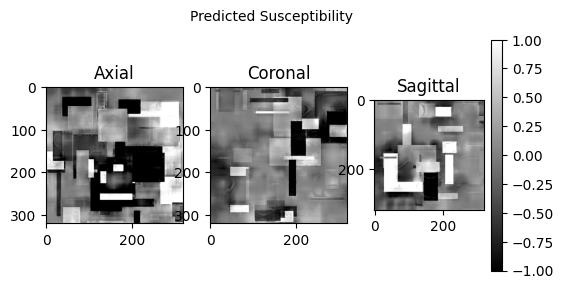

In [ ]:
# and predicting on the full data?
X_test = sim_fw_full[np.newaxis, :, :, :, np.newaxis]
print(X_test.shape)

y_pred = model1.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(sim_gt_full[:, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


(1, 160, 160, 160, 1)
1/1 [==============================] - 0s 37ms/step
(1, 160, 160, 160, 1)
Matrix size: (160, 160, 160)
Matrix size: (160, 160, 160)
Matrix size: (160, 160, 160)


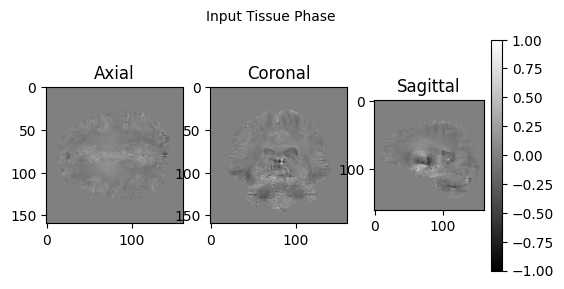

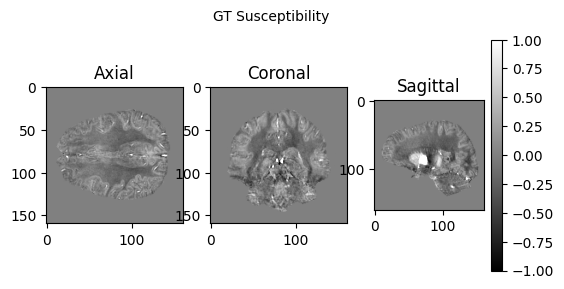

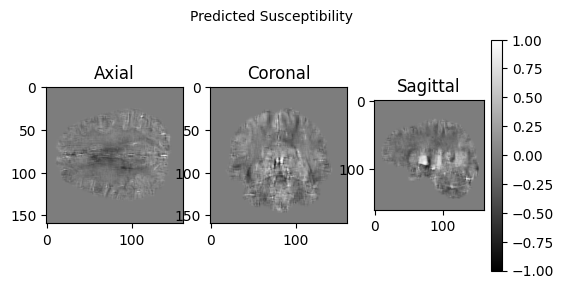

In [ ]:
# and predicting on the brain data?
X_test = brain_fw_full[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = model1.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(brain_gt_full[:, :, :]*10, slice_nbr=100, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Predicted Susceptibility')

# Train Model 2

## Prepare

In [ ]:
def architecture2(filter_base=64, kernel_size=3):
  down_stack = [
    downsample(filter_base, kernel_size, apply_batchnorm=False), # (bs, 32xxx 64 if filter base = 64)
    downsample(filter_base*2, kernel_size), # (bs, 16xxx, 128)
    downsample(filter_base*3, kernel_size), # (bs, 8xxx, 256)
    downsample(filter_base*4, kernel_size), # (bs, 4xxx, 512)
    downsample(filter_base*5, kernel_size), # (bs, 2xxx, 512)
  ]

  up_stack = [
    upsample(filter_base*5, kernel_size, apply_dropout=True), # (bs, 16, 16, 1024)
    upsample(filter_base*4, kernel_size, apply_dropout=True), # (bs, 32, 32, 512)
    upsample(filter_base*3, kernel_size), # (bs, 64, 64, 256)
    upsample(filter_base*2, kernel_size), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS, kernel_size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,None,1])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model2 = architecture2()
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

## Train

In [ ]:
import os
import tensorflow as tf
# train
checkpoint_path2 = "checkpoints2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
sim_gt_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))
sim_fw_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path2,
                                                 save_weights_only=True,
                                                 period=100,
                                                 verbose=1)

train_images=tf.expand_dims(sim_fw_patches, 4)
train_labels=tf.expand_dims(sim_gt_patches, 4)


history2 = model2.fit(train_images, train_labels,  epochs=100, batch_size=30, shuffle=True,
          callbacks = [cp_callback])  # pass callback to training for saving the model

loss_history2 = history2.history['loss']

import pickle
with open('loss_history2.pickle', 'wb') as f:
    pickle.dump([loss_history2, 100], f)

## Load and Plot

In [ ]:
# load stored data
checkpoint_path2 = "checkpoints2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = architecture2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

with open('loss_history2.pickle', 'rb') as f:
    [loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="loss2")
ax.set_xlabel('epoch')
ax.legend(frameon=False);


In [ ]:
# did we manage to learn the training data?
test_patch_nbr = 4
X_test = sim_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(X_test.shape)

y_pred = model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(sim_gt_patches[test_patch_nbr, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


In [ ]:
# and predicting on the full data?
X_test = sim_fw_full[np.newaxis, :, :, :, np.newaxis]
print(X_test.shape)

y_pred = model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(sim_gt_full[:, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


In [ ]:
# and predicting on the brain data?
X_test = brain_fw_full[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(brain_gt_full[:, :, :]*10, slice_nbr=100, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Predicted Susceptibility')

# Compare Model 1 and 2


In [ ]:
with open('loss_history1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history2.pickle', 'rb') as f:
    [loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="blue", label="loss2")
ax.set_xlabel('epoch')
ax.legend(frameon=False);
plt.ylim((0, 0.2))